In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import sys
import os
from pathlib import Path

In [2]:
sys.path.append('../src')
from physics.RICH_simulator import RICHSimulator
from physics import constants
from utils import visualisations, metrics



In [3]:
data_path = Path('../data/processed/rich_images_fixed_momentum_pi_10.0GeV.npz') #rich_images_combined_events.npz')
# Load the dataset
data = np.load(data_path)
images = data['images']

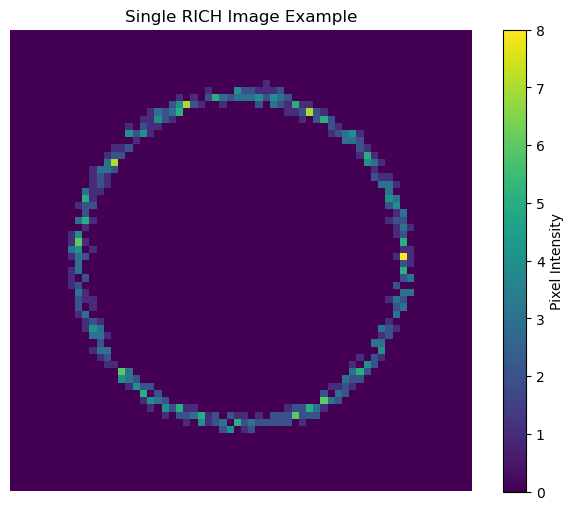

In [4]:
# Display a grid of 9 images
#visualisations.display_image_grid(images, num_images=9)
plt.figure(figsize=(8, 6))
img = plt.imshow(images[40], cmap='viridis')
plt.title('Single RICH Image Example')
plt.colorbar(img, label='Pixel Intensity')
plt.axis('off')
plt.show()

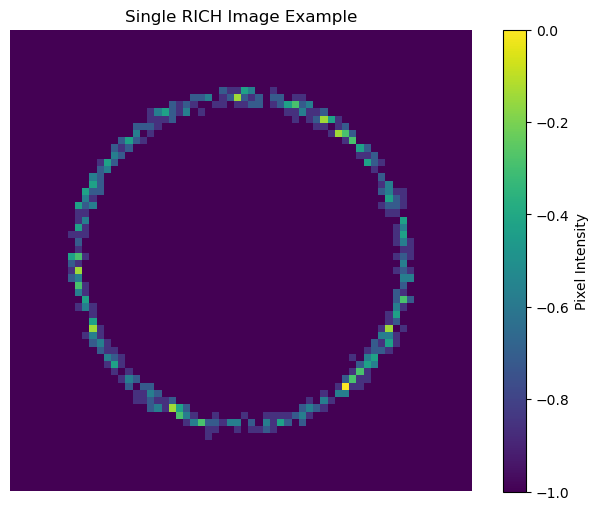

In [5]:
# Normalise images for Diffusion modelling
max_value = np.max(images)
#normalised_images = metrics.normalise_rich_images(images, max_value)
normalised_images = (images / max_value) * 2 - 1  # Scale to [-1, 1]
#normalised_images = (images - np.mean(images)) / np.std(images)
plt.figure(figsize=(8, 6))
img = plt.imshow(normalised_images[4], cmap='viridis')
plt.title('Single RICH Image Example')
plt.colorbar(img, label='Pixel Intensity')
plt.axis('off')
plt.show()

In [6]:
# Ensure correct shape: (num_samples, height, width, channels)
if len(normalised_images.shape) == 3:
    normalised_images = normalised_images[..., np.newaxis]

print(f"Dataset shape: {normalised_images.shape}")
print(f"Value range: [{normalised_images.min():.3f}, {normalised_images.max():.3f}]")


Dataset shape: (5000, 64, 64, 1)
Value range: [-1.000, 1.000]


In [7]:
from ml.diffusion.rich_ddpm import RICHDDPM
from ml.diffusion.trainer import RICHTrainer
from ml.diffusion.unet import UNet
from ml.diffusion.unet_pytorch import PyTorchUNet
from ml.diffusion.visualiser import RICHVisualiser

In [8]:
IMAGE_SIZE = 32
TIMESTEPS = 1000
BATCH_SIZE = 2  # Small for debugging
EPOCHS = 3
LEARNING_RATE = 1e-6

print("Step 1: Creating and verifying DDPM...")
ddpm = RICHDDPM(image_size=IMAGE_SIZE, timesteps=TIMESTEPS)

print("\nStep 2: Running comprehensive alpha verification...")
alpha_ok = ddpm.verify_alpha_calculations()

if not alpha_ok:
    print("❌ Alpha verification failed! Fix this before proceeding.")
    exit(1)

print("\nStep 3: Testing noise addition with sample image...")
sample_image = normalised_images[0:1]
test_timesteps = [0, TIMESTEPS//2, TIMESTEPS-1]

for t in test_timesteps:
    ddpm.debug_noise_addition(sample_image, t)

print("\nStep 4: Verifying variance preservation...")
variance_ok = ddpm._verify_variance_preservation()

if not variance_ok:
    print("❌ Variance preservation failed! Fix this before training.")
    exit(1)

print("\nStep 5: All verifications passed! Proceeding with training...")

Step 1: Creating and verifying DDPM...
=== Basic Alpha Verification ===
α_0: 0.999900 (should be close to 1)
α_999: 0.800000 (should be close to 0)
√ᾱ_0: 0.999950 (should be 1)
√ᾱ_999: 0.000000 (should be close to 0)
✅ Basic verification completed
DDPM initialized: image_size=32, timesteps=1000
Beta range: [0.000100, 0.200000]

Step 2: Running comprehensive alpha verification...

COMPREHENSIVE ALPHA CALCULATIONS VERIFICATION

1. Alpha progression check:
   α_0: 0.999900
   α_250: 0.949875
   α_500: 0.899850
   α_750: 0.849825
   α_999: 0.800000
✅ ᾱ_t calculation is correct (cumulative product of α_t)

2. √ᾱ_t progression:
   √ᾱ_0: 0.999950 (should be 1.0)
   √ᾱ_999: 0.000000 (should be close to 0)

3. √(1-ᾱ_t) progression:
   √(1-ᾱ_0): 0.010001 (should be 0.0)
   √(1-ᾱ_999): 1.000000 (should be close to 1)

4. Mathematical property check:
   At t=500: ᾱ_t + (1-ᾱ_t) = 0.000000 + 1.000000 = 1.000000 (should be 1.0)
✅ Mathematical property verified

🎉 All alpha calculations ver

In [ ]:
import torch
import numpy as np
from ml.diffusion.richddpm_pytorch import RICHDDPM
from ml.diffusion.unet_pytorch import PyTorchUNet
from ml.diffusion.visualiser_pytorch import RICHVisualiser, StochasticProcessVisualiser
from ml.diffusion.trainer_pytorch import RICHTrainer

# Configuration
IMAGE_SIZE = 32
TIMESTEPS = 300
BATCH_SIZE = 32 #1000
EPOCHS = 30 #50 #100
LEARNING_RATE = 1e-5

# Initialize components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ddpm = RICHDDPM(image_size=IMAGE_SIZE, timesteps=TIMESTEPS)
unet = PyTorchUNet(image_size=IMAGE_SIZE, in_channels=1, base_channels=32)
visualiser = RICHVisualiser()
trainer = RICHTrainer(ddpm, unet, visualiser, learning_rate=LEARNING_RATE)

# Visualize forward process (convert to numpy for visualization)
sample_image = torch.FloatTensor(normalised_images[0:1])  # Shape: (1, 32, 32, 1)
sample_image = sample_image.permute(0, 3, 1, 2).to(device)  # Convert to channel-first
visualiser.plot_forward_process(ddpm, sample_image)

# Train the model - THIS IS WHERE training_step GETS CALLED!
trainer.train(normalised_images, epochs=EPOCHS, batch_size=BATCH_SIZE)
visualiser.plot_reverse_process(ddpm, unet, num_steps=8)
# Generate final samples
#print("\nGenerating final samples...")
#final_samples, intermediate_samples = ddpm.generate_samples(unet, num_samples=5)



DDPM initialized on device: cpu
PyTorch UNet initialized with 14,169,281 parameters
RICHVisualiser initialised. Output directory: rich_diffusion_visualisations
Trainer initialized on device: cpu
Learning rate: 1e-05
Forward process visualisation saved: forward_diffusion_process.png
Starting training on 5000 images
Epochs: 30, Batch size: 32
Steps per epoch: 157
Epoch 1/30, Batch 0/157, Loss: 1.324008


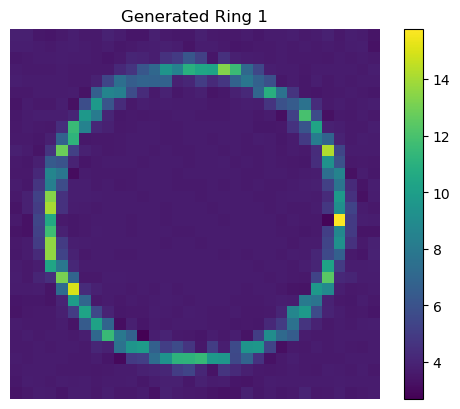

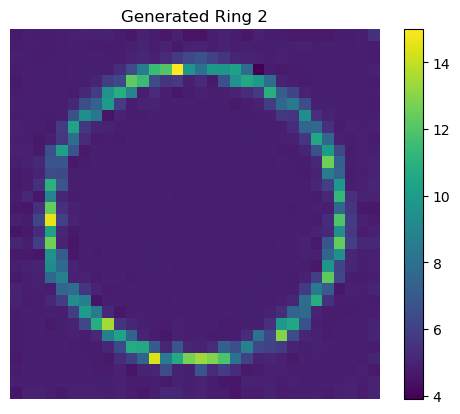

In [10]:
# === Visualise Generated Rings (Undo Scaling) ===

# Number of samples to generate
num_gen = 2
final_samples, intermediate_samples = ddpm.generate_samples(unet, num_samples=num_gen)

# Convert generated samples to numpy and undo scaling
for i in range(num_gen):
    gen_tensor = final_samples[i:i+1]  # shape: (1, C, H, W)
    gen_np = visualiser._tensor_to_numpy(gen_tensor)  # (1, H, W, C)
    
    # Undo [-1,1] scaling back to [0, max_value]
    gen_rescaled = ((gen_np[0, :, :, 0] + 1) / 2.0) * max_value
    
    # Show image
    plt.imshow(gen_rescaled, cmap=visualiser.cmap)
    plt.title(f"Generated Ring {i+1}")
    plt.axis("off")
    plt.colorbar()
    plt.show()

In [11]:
from scipy.stats import norm
from ml.diffusion.visualiser_pytorch import StochasticProcessVisualiser, DiffusionAnalysisVisualiser
# Create stochastic analysis before training
stochastic_vis = StochasticProcessVisualiser() 
stochastic_vis.plot_stochastic_process_illustration()
#visualiser.create_diffusion_animation()
#visualiser.plot_comparison_grid()

All stochastic process illustrations saved individually.


In [12]:
analyser = DiffusionAnalysisVisualiser()
# Plot 1: Variance schedule analysis
analyser.plot_variance_schedule(ddpm)
    
# Plot 2: ELBO components analysis
#analyser.plot_elbo_components(ddpm)
    
# Plot 3: Reparameterization trick importance
analyser.plot_reparameterization_trick(ddpm)
    
# Plot 4: Jensen's inequality in VLB
analyser.plot_jensen_inequality_analysis(ddpm)
    
# Plot 5: Training dynamics (if trainer available)
if trainer is not None:
    analyser.plot_training_dynamics(trainer)

Variance schedule plot saved: variance_schedule.png
Reparameterization trick plot saved: reparameterization.png
Jensen's inequality analysis plot saved: jensen_inequality.png
Training dynamics plot saved: training_dynamics.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, gaussian_kde
from scipy.optimize import curve_fit, minimize
import torch
import yaml
from pathlib import Path

class FixedMomentumRICHAnalyzer:
    def __init__(self, config):
        self.config = config
        self.n = config['simulator']['refractive_index']
        self.pixel_pitch = config['simulator']['pixel_pitch']
        self.detector_distance = config['simulator']['detector_distance']
        self.image_size = config['simulator']['image_size']
        # Fixed center at image center
        self.center_pixel = np.array([self.image_size//2, self.image_size//2])
        
    def reconstruct_cherenkov_angle(self, image):
        """
        Reconstruct Cherenkov angle with FIXED center at image center
        Only optimize the radius
        """
        if np.max(image) <= 0:
            return None, None, None
            
        threshold = np.percentile(image[image > 0], 30) if np.any(image > 0) else 0
        y_indices, x_indices = np.where(image > threshold)
        
        if len(x_indices) < 20:
            return None, None, None
        
        # Use fixed center at image center
        center_x, center_y = self.center_pixel
        
        # Convert to physical coordinates
        x_pos = (x_indices - center_x) * self.pixel_pitch
        y_pos = (y_indices - center_y) * self.pixel_pitch
        
        # Calculate distances from center
        radii = np.sqrt(x_pos**2 + y_pos**2)
        
        # Use histogram to find initial radius estimate
        hist, bin_edges = np.histogram(radii, bins=50, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        max_bin_idx = np.argmax(hist)
        initial_radius = bin_centers[max_bin_idx]
        
        # Refine radius using optimization (center is fixed)
        try:
            optimized_radius = self._optimize_ring_radius(image, initial_radius)
            final_radius = optimized_radius
        except:
            # If optimization fails, use histogram method
            final_radius = initial_radius
        
        # Convert radius to Cherenkov angle
        theta_c = np.arctan(final_radius / self.detector_distance)
        
        # Calculate ring quality
        ring_quality = self._calculate_ring_quality(radii, final_radius)
        
        return theta_c, ring_quality, final_radius, self.center_pixel
    
    def _optimize_ring_radius(self, image, initial_radius):
        """Optimize only the ring radius using least squares fitting with fixed center"""
        # Get hit positions with intensities
        y_indices, x_indices = np.where(image > 0)
        intensities = image[y_indices, x_indices]
        
        # Normalize intensities for weighting
        if np.sum(intensities) > 0:
            weights = intensities / np.sum(intensities)
        else:
            weights = np.ones_like(intensities) / len(intensities)
        
        def radius_residuals(radius):
            center_x, center_y = self.center_pixel
            
            # Convert to physical coordinates
            x_phys = (x_indices - center_x) * self.pixel_pitch
            y_phys = (y_indices - center_y) * self.pixel_pitch
            distances = np.sqrt(x_phys**2 + y_phys**2)
            
            # Residuals: difference between actual distances and desired radius
            residuals = (distances - radius) * weights
            
            return np.sum(residuals**2)
        
        # Set bounds for radius optimization
        bounds = [(initial_radius * 0.5, initial_radius * 1.5)]
        
        result = minimize(radius_residuals, [initial_radius], method='L-BFGS-B', bounds=bounds)
        
        if result.success:
            return result.x[0]
        else:
            raise RuntimeError("Radius optimization failed")
    
    def _calculate_ring_quality(self, radii, estimated_radius):
        """Calculate ring quality based on how concentrated hits are around the ring"""
        if len(radii) < 10:
            return 0.0
            
        # Calculate what fraction of hits are within 20% of the estimated radius
        within_ring = np.sum((radii > estimated_radius * 0.8) & (radii < estimated_radius * 1.2))
        fraction_in_ring = within_ring / len(radii)
        
        # Calculate how peaked the radial distribution is
        quality = fraction_in_ring * (1 - np.std(radii) / (estimated_radius + 1e-8))
        
        return np.clip(quality, 0, 1)
    
    def calculate_particle_mass(self, theta_c, momentum):
        """Calculate particle mass from Cherenkov angle and known momentum"""
        if theta_c is None or momentum <= 0:
            return None
            
        cos_theta = np.cos(theta_c)
        if cos_theta <= 1e-8:
            return None
            
        beta = 1.0 / (self.n * cos_theta)
        
        # Check for unphysical beta values
        if beta >= 1.0 or beta <= 0:
            return None
            
        mass_squared = (momentum**2) * (1.0/(beta**2) - 1.0)
        if mass_squared < 0:
            return None
            
        mass = momentum * np.sqrt(1.0/(beta**2) - 1.0)
        return mass

    def analyze_image_detailed(self, image):
        """Detailed analysis of a single image with visualization"""
        if np.max(image) <= 0:
            return None, None, None, None, None, None
            
        threshold = np.percentile(image[image > 0], 30) if np.any(image > 0) else 0
        y_indices, x_indices = np.where(image > threshold)
        
        if len(x_indices) < 20:
            return None, None, None, None, None, None
        
        # Use the improved reconstruction with fixed center
        theta_c, quality, radius, center_pixel = self.reconstruct_cherenkov_angle(image)
        
        if theta_c is None:
            return None, None, None, None, None, None
            
        # Recalculate radii for visualization
        x_pos = (x_indices - center_pixel[0]) * self.pixel_pitch
        y_pos = (y_indices - center_pixel[1]) * self.pixel_pitch
        radii = np.sqrt(x_pos**2 + y_pos**2)
        
        mass = self.calculate_particle_mass(theta_c, 10.0)
        
        return theta_c, mass, quality, radii, radius, center_pixel

class FixedMomentumDDPMEvaluator:
    def __init__(self, ddpm, unet, analyzer, config, fixed_momentum=10.0):
        self.ddpm = ddpm
        self.unet = unet
        self.analyzer = analyzer
        self.config = config
        self.fixed_momentum = fixed_momentum
        self.image_size = config['simulator']['image_size']
        self.max_value = None
        
    def set_training_data(self, training_images):
        self.training_images = training_images
        self.max_value = np.max(training_images)
        
    def evaluate_mass_reconstruction(self, num_generated_images=50):
        print(f"Evaluating mass reconstruction at {self.fixed_momentum} GeV/c")
        print(f"Training images: {len(self.training_images)}")
        print(f"Generated images: {num_generated_images}")
        
        # Reconstruct masses from training images
        print("Reconstructing masses from training images...")
        training_masses = self._reconstruct_masses_from_images(
            self.training_images, "Training"
        )
        
        # Generate DDPM images and reconstruct masses
        print("Generating DDPM images and reconstructing masses...")
        generated_images = self._generate_ddpm_images(num_generated_images)
        ddpm_masses = self._reconstruct_masses_from_images(
            generated_images, "DDPM"
        )
        
        results = {
            'fixed_momentum': self.fixed_momentum,
            'training_images': self.training_images,
            'generated_images': generated_images,
            'training_masses': training_masses,
            'ddpm_masses': ddpm_masses,
            'expected_mass': 0.13957
        }
        
        return results
    
    def _generate_ddpm_images(self, num_images):
        generated_images = []
        
        for i in range(num_images):
            if i % 10 == 0:
                print(f"Generating DDPM image {i+1}/{num_images}")
            ddpm_image = self._generate_single_ddpm_image()
            generated_images.append(ddpm_image)
            
        return np.array(generated_images)
    
    def _generate_single_ddpm_image(self):
        self.unet.eval()
        
        with torch.no_grad():
            num_samples = 1
            device = self.ddpm.device
            
            x = torch.randn((num_samples, 1, self.ddpm.image_size, self.ddpm.image_size), device=device)
            
            for i in range(self.ddpm.timesteps - 1, -1, -1):
                t = torch.tensor([i] * num_samples, device=device)
                x, pred_x0, _ = self.ddpm.reverse_diffusion_step(self.unet, x, t)
            
            sample = x.detach().cpu().numpy()[0, 0]
            sample_rescaled = ((sample + 1) / 2.0) * self.max_value
            
            return sample_rescaled
    
    def _reconstruct_masses_from_images(self, images, source_name):
        masses = []
        valid_images = 0
        
        for i, img in enumerate(images):
            theta_c, quality, radius, center = self.analyzer.reconstruct_cherenkov_angle(img)
            
            if theta_c is not None and quality > 0.01:
                mass = self.analyzer.calculate_particle_mass(theta_c, self.fixed_momentum)
                if mass is not None and mass > 0:
                    masses.append(mass)
                    valid_images += 1
        
        print(f"  {source_name}: {valid_images}/{len(images)} images produced valid mass reconstructions")
        return np.array(masses)

    def plot_detailed_analysis(self, images, title, num_images=3):
        """Plot detailed analysis of sample images with FIXED center ring overlay"""
        fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
        if num_images == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(num_images):
            if i >= len(images):
                break
                
            img = images[i]
            theta_c, mass, quality, radii, estimated_radius, center_pixel = self.analyzer.analyze_image_detailed(img)
            
            # Plot image with ring overlay
            axes[i, 0].imshow(img, cmap='viridis')
            axes[i, 0].set_title(f'{title} Image {i+1}')
            
            # Draw the detected ring with FIXED center
            if estimated_radius is not None and center_pixel is not None:
                # Convert radius from meters to pixels
                radius_pixels = estimated_radius / self.analyzer.pixel_pitch
                
                # Create circle with fixed center
                circle = plt.Circle((center_pixel[0], center_pixel[1]), radius_pixels, 
                                  color='red', fill=False, linewidth=2, linestyle='--')
                axes[i, 0].add_patch(circle)
                
                # Mark center
                axes[i, 0].plot(center_pixel[0], center_pixel[1], 'r+', markersize=10, markeredgewidth=2)
                
                # Show center coordinates (should be exactly image center)
                axes[i, 0].set_xlabel(f'Center: ({center_pixel[0]:.1f}, {center_pixel[1]:.1f})')
            
            axes[i, 0].axis('off')
            
            # Plot radial distribution
            if radii is not None:
                axes[i, 1].hist(radii, bins=30, alpha=0.7, density=True)
                if estimated_radius is not None:
                    axes[i, 1].axvline(estimated_radius, color='red', linestyle='--', 
                                     label=f'Detected radius: {estimated_radius:.4f} m')
                axes[i, 1].set_xlabel('Radius (m)')
                axes[i, 1].set_ylabel('Density')
                axes[i, 1].set_title('Radial Distribution')
                axes[i, 1].legend()
                axes[i, 1].grid(True, alpha=0.3)
            else:
                axes[i, 1].text(0.5, 0.5, 'No ring detected', ha='center', va='center')
                axes[i, 1].axis('off')
            
            # Plot analysis info
            axes[i, 2].axis('off')
            if theta_c is not None and mass is not None and estimated_radius is not None:
                ring_radius_pixels = estimated_radius / self.analyzer.pixel_pitch
                info_text = (
                    f"Cherenkov angle: {np.degrees(theta_c):.3f}°\n"
                    f"Ring radius: {estimated_radius:.4f} m\n"
                    f"Ring radius (pixels): {ring_radius_pixels:.2f}\n"
                    f"Center (fixed): ({center_pixel[0]:.1f}, {center_pixel[1]:.1f})\n"
                    f"Reconstructed mass: {mass:.4f} GeV/c²\n"
                    f"Expected mass: 0.13957 GeV/c²\n"
                    f"Ring quality: {quality:.3f}\n"
                    f"Momentum: {self.fixed_momentum} GeV/c"
                )
            else:
                info_text = "Could not reconstruct ring\nor unphysical mass result"
            
            axes[i, 2].text(0.1, 0.5, info_text, fontsize=12, verticalalignment='center',
                           bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

    def plot_ring_comparison_grid(self, training_images, generated_images, num_images=5):
        """Plot side-by-side comparison of training and generated images with FIXED center ring overlays"""
        fig, axes = plt.subplots(2, num_images, figsize=(20, 8))
        
        # Plot training images
        for i in range(num_images):
            if i >= len(training_images):
                break
                
            img = training_images[i]
            theta_c, mass, quality, radii, estimated_radius, center_pixel = self.analyzer.analyze_image_detailed(img)
            
            axes[0, i].imshow(img, cmap='viridis')
            axes[0, i].set_title(f'Training Image {i+1}')
            
            if estimated_radius is not None and center_pixel is not None:
                radius_pixels = estimated_radius / self.analyzer.pixel_pitch
                circle = plt.Circle((center_pixel[0], center_pixel[1]), radius_pixels, 
                                  color='red', fill=False, linewidth=2, linestyle='--')
                axes[0, i].add_patch(circle)
                axes[0, i].plot(center_pixel[0], center_pixel[1], 'r+', markersize=10, markeredgewidth=2)
                
                if mass is not None:
                    axes[0, i].set_xlabel(f'Mass: {mass:.4f} GeV/c²')
            
            axes[0, i].axis('off')
        
        # Plot generated images
        for i in range(num_images):
            if i >= len(generated_images):
                break
                
            img = generated_images[i]
            theta_c, mass, quality, radii, estimated_radius, center_pixel = self.analyzer.analyze_image_detailed(img)
            
            axes[1, i].imshow(img, cmap='viridis')
            axes[1, i].set_title(f'DDPM Image {i+1}')
            
            if estimated_radius is not None and center_pixel is not None:
                radius_pixels = estimated_radius / self.analyzer.pixel_pitch
                circle = plt.Circle((center_pixel[0], center_pixel[1]), radius_pixels, 
                                  color='red', fill=False, linewidth=2, linestyle='--')
                axes[1, i].add_patch(circle)
                axes[1, i].plot(center_pixel[0], center_pixel[1], 'r+', markersize=10, markeredgewidth=2)
                
                if mass is not None:
                    axes[1, i].set_xlabel(f'Mass: {mass:.4f} GeV/c²')
            
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()

    def plot_radius_distribution(self, images, title):
        """Plot the distribution of detected ring radii"""
        radii = []
        masses = []
        
        for img in images:
            theta_c, mass, quality, radii_list, estimated_radius, center_pixel = self.analyzer.analyze_image_detailed(img)
            if estimated_radius is not None and mass is not None:
                radii.append(estimated_radius)
                masses.append(mass)
        
        if radii:
            plt.figure(figsize=(12, 5))
            
            # Radius distribution
            plt.subplot(1, 2, 1)
            plt.hist(radii, bins=20, alpha=0.7, color='blue')
            plt.xlabel('Ring Radius (m)')
            plt.ylabel('Frequency')
            plt.title(f'{title} - Ring Radius Distribution')
            plt.grid(True, alpha=0.3)
            
            # Mass distribution
            plt.subplot(1, 2, 2)
            plt.hist(masses, bins=20, alpha=0.7, color='green')
            plt.axvline(x=0.13957, color='red', linestyle='--', label='Expected π mass')
            plt.xlabel('Reconstructed Mass (GeV/c²)')
            plt.ylabel('Frequency')
            plt.title(f'{title} - Mass Distribution')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print(f"Mean radius: {np.mean(radii):.4f} ± {np.std(radii):.4f} m")
            print(f"Mean mass: {np.mean(masses):.4f} ± {np.std(masses):.4f} GeV/c²")
            print(f"Expected mass: 0.13957 GeV/c²")
            print(f"Mass bias: {(np.mean(masses) - 0.13957) / 0.13957 * 100:.2f}%")

    def plot_mass_comparison(self, results, filename=None):
        """Plot comprehensive mass comparison"""
        if filename is None:
            filename = f"mass_comparison_{results['fixed_momentum']}GeV.png"
        
        training_masses = results['training_masses']
        ddpm_masses = results['ddpm_masses']
        expected_mass = results['expected_mass']
        
        # Calculate metrics
        metrics = self._calculate_metrics(training_masses, ddpm_masses, expected_mass)
        
        plt.figure(figsize=(15, 12))
        
        # Plot 1: Mass distributions
        plt.subplot(2, 3, 1)
        if len(training_masses) > 0 and len(ddpm_masses) > 0:
            # Use adaptive binning
            all_masses = np.concatenate([training_masses, ddpm_masses])
            mass_min = min(all_masses)
            mass_max = max(all_masses)
            bins = np.linspace(mass_min * 0.9, mass_max * 1.1, 30)
            
            plt.hist(training_masses, bins=bins, alpha=0.7, label='Training Data', 
                    density=True, color='blue', edgecolor='black')
            plt.hist(ddpm_masses, bins=bins, alpha=0.7, label='DDPM Generated', 
                    density=True, color='red', edgecolor='black')
            
            plt.axvline(x=expected_mass, color='green', linestyle='--', 
                       linewidth=2, label=f'Expected: {expected_mass:.4f} GeV/c²')
            
            plt.xlabel('Reconstructed Mass (GeV/c²)')
            plt.ylabel('Probability Density')
            plt.title(f'Mass Distribution at {results["fixed_momentum"]} GeV/c')
            plt.legend()
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No valid mass reconstructions', ha='center', va='center')
            plt.axis('off')
        
        # Plot 2: Example training image with ring
        plt.subplot(2, 3, 2)
        if len(results['training_images']) > 0:
            img = results['training_images'][0]
            theta_c, mass, quality, radii, estimated_radius, center_pixel = self.analyzer.analyze_image_detailed(img)
            
            plt.imshow(img, cmap='viridis')
            plt.title('Training Image with Ring')
            
            if estimated_radius is not None and center_pixel is not None:
                radius_pixels = estimated_radius / self.analyzer.pixel_pitch
                circle = plt.Circle((center_pixel[0], center_pixel[1]), radius_pixels, 
                                  color='red', fill=False, linewidth=2, linestyle='--')
                plt.gca().add_patch(circle)
                plt.plot(center_pixel[0], center_pixel[1], 'r+', markersize=10, markeredgewidth=2)
                
            plt.colorbar()
            plt.axis('off')
        
        # Plot 3: Example generated image with ring
        plt.subplot(2, 3, 3)
        if len(results['generated_images']) > 0:
            img = results['generated_images'][0]
            theta_c, mass, quality, radii, estimated_radius, center_pixel = self.analyzer.analyze_image_detailed(img)
            
            plt.imshow(img, cmap='viridis')
            plt.title('DDPM Image with Ring')
            
            if estimated_radius is not None and center_pixel is not None:
                radius_pixels = estimated_radius / self.analyzer.pixel_pitch
                circle = plt.Circle((center_pixel[0], center_pixel[1]), radius_pixels, 
                                  color='red', fill=False, linewidth=2, linestyle='--')
                plt.gca().add_patch(circle)
                plt.plot(center_pixel[0], center_pixel[1], 'r+', markersize=10, markeredgewidth=2)
                
            plt.colorbar()
            plt.axis('off')
        
        # Plot 4: Statistical comparison
        plt.subplot(2, 3, 4)
        plt.axis('off')
        
        summary_text = (
            f"Fixed Momentum: {results['fixed_momentum']} GeV/c\n"
            f"Expected Mass: {expected_mass:.4f} GeV/c²\n\n"
            f"Training Images: {len(results['training_images'])}\n"
            f"Generated Images: {len(results['generated_images'])}\n"
            f"Training Mass Reconstructions: {len(training_masses)}\n"
            f"DDPM Mass Reconstructions: {len(ddpm_masses)}\n\n"
        )
        
        if len(training_masses) > 0 and len(ddpm_masses) > 0:
            summary_text += (
                f"KS p-value: {metrics['ks_pvalue']:.4f}\n"
                f"Mass Bias: {metrics['bias_percent']:.2f}%\n"
                f"Training Mean Mass: {metrics['training_mean']:.4f} ± {metrics['training_std']:.4f}\n"
                f"DDPM Mean Mass: {metrics['ddpm_mean']:.4f} ± {metrics['ddpm_std']:.4f}"
            )
        else:
            summary_text += "Insufficient data for statistical comparison"
        
        plt.text(0.1, 0.9, summary_text, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Plot 5: KDE comparison
        plt.subplot(2, 3, 5)
        if len(training_masses) > 2 and len(ddpm_masses) > 2:
            training_kde = gaussian_kde(training_masses)
            ddpm_kde = gaussian_kde(ddpm_masses)
            
            mass_grid = np.linspace(min(all_masses), max(all_masses), 200)
            training_pdf = training_kde(mass_grid)
            ddpm_pdf = ddpm_kde(mass_grid)
            
            plt.plot(mass_grid, training_pdf, 'b-', linewidth=2, label='Training')
            plt.plot(mass_grid, ddpm_pdf, 'r-', linewidth=2, label='DDPM')
            plt.axvline(x=expected_mass, color='green', linestyle='--', label='Expected')
            
            plt.xlabel('Mass (GeV/c²)')
            plt.ylabel('Probability Density')
            plt.title('KDE Comparison')
            plt.legend()
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'Insufficient data for KDE', ha='center', va='center')
            plt.axis('off')
        
        # Plot 6: Reconstruction efficiency
        plt.subplot(2, 3, 6)
        categories = ['Training Data', 'DDPM Generated']
        efficiencies = [
            len(training_masses) / len(results['training_images']) if len(results['training_images']) > 0 else 0,
            len(ddpm_masses) / len(results['generated_images']) if len(results['generated_images']) > 0 else 0
        ]
        
        bars = plt.bar(categories, efficiencies, color=['blue', 'red'], alpha=0.7)
        plt.ylabel('Mass Reconstruction Efficiency')
        plt.title('Reconstruction Efficiency')
        plt.ylim(0, 1)
        
        # Add values on bars
        for bar, eff in zip(bars, efficiencies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{eff:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"Comparison plot saved: {filename}")
        return metrics
    
    def _calculate_metrics(self, training_masses, ddpm_masses, expected_mass):
        """Calculate performance metrics"""
        if len(training_masses) > 0 and len(ddpm_masses) > 0:
            ks_stat, ks_pvalue = ks_2samp(training_masses, ddpm_masses)
            training_mean, training_std = np.mean(training_masses), np.std(training_masses)
            ddpm_mean, ddpm_std = np.mean(ddpm_masses), np.std(ddpm_masses)
            bias_percent = (ddpm_mean - training_mean) / training_mean * 100
        else:
            ks_pvalue = 0.0
            training_mean = training_std = ddpm_mean = ddpm_std = bias_percent = 0.0
        
        return {
            'ks_pvalue': ks_pvalue,
            'training_mean': training_mean,
            'training_std': training_std,
            'ddpm_mean': ddpm_mean,
            'ddpm_std': ddpm_std,
            'bias_percent': bias_percent
        }

Training images shape: (5000, 32, 32)
Training images range: [0.000, 22.000]
=== Detailed Analysis of Training Images ===


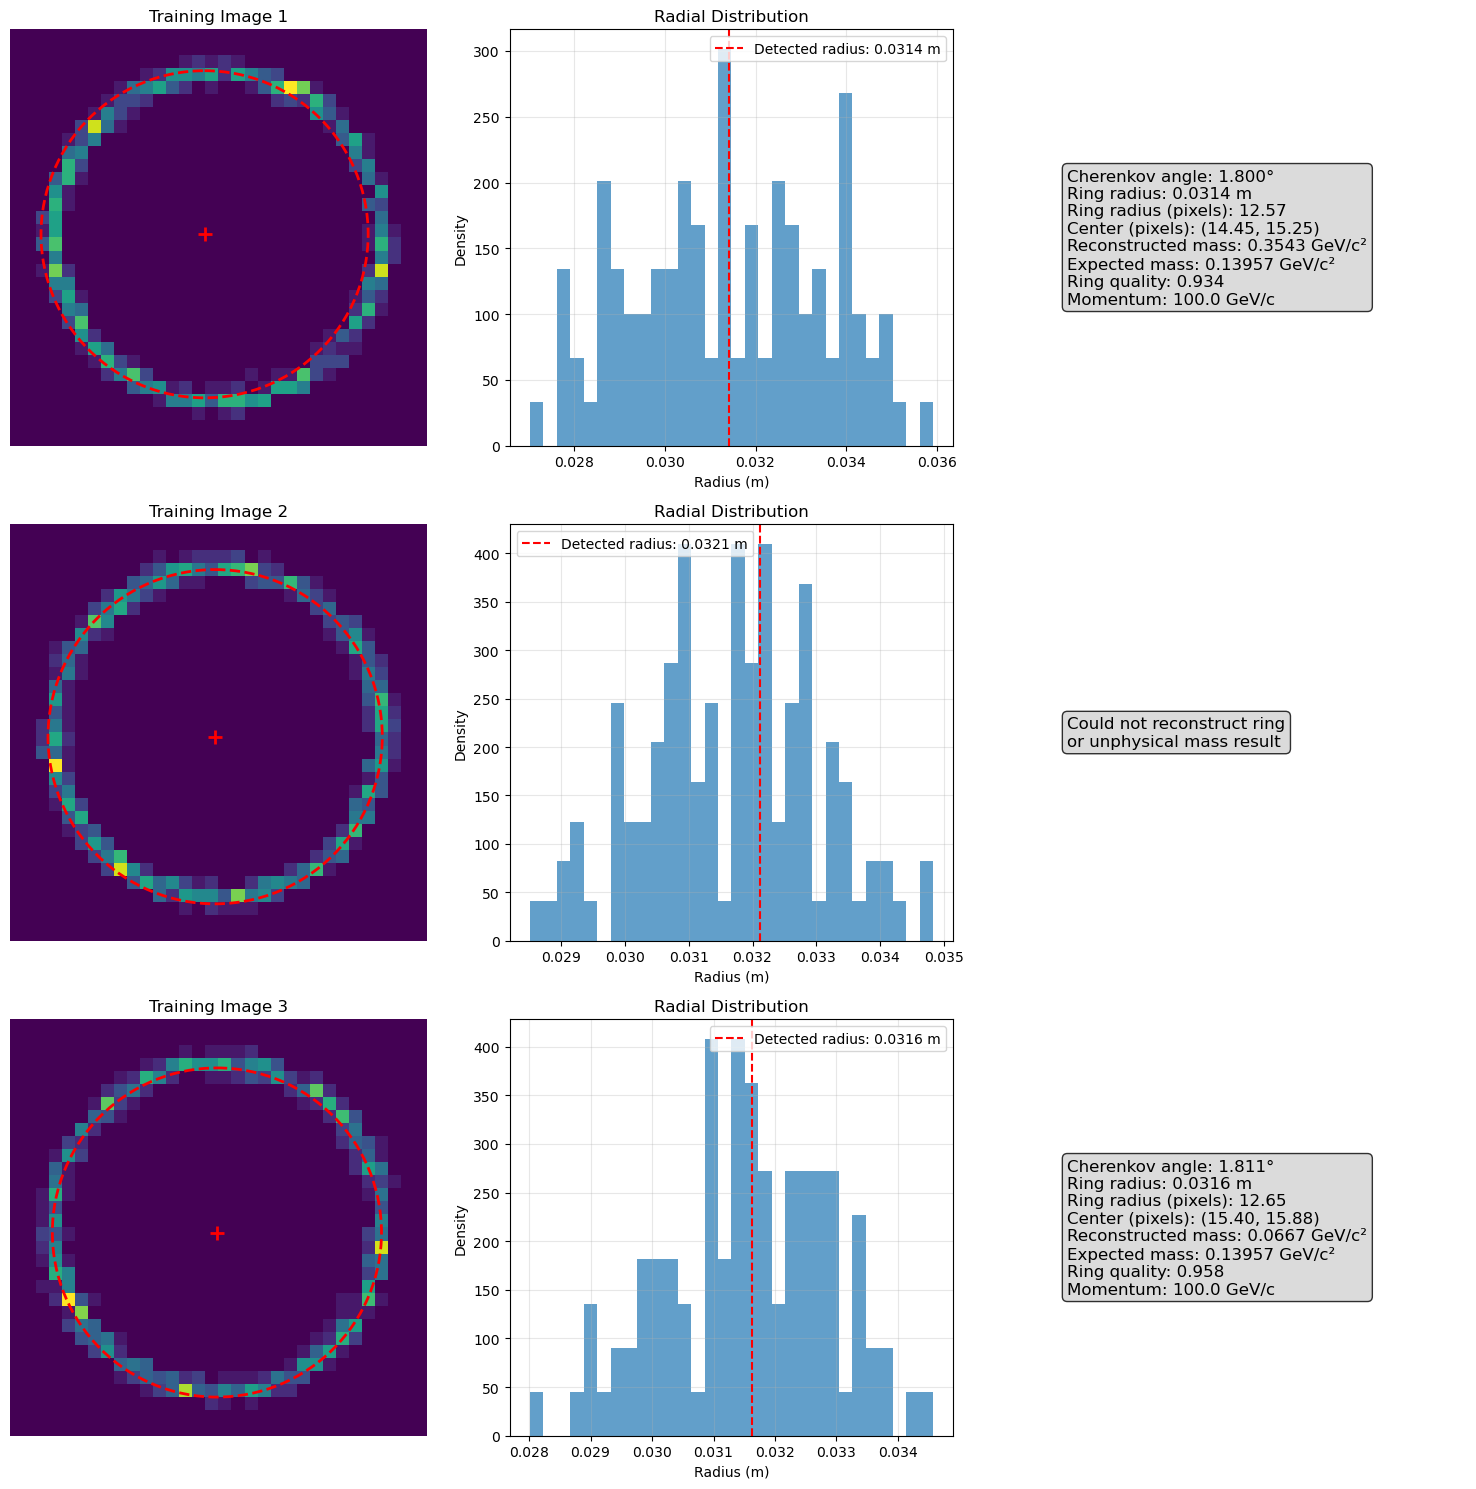

=== Center Distribution Analysis ===


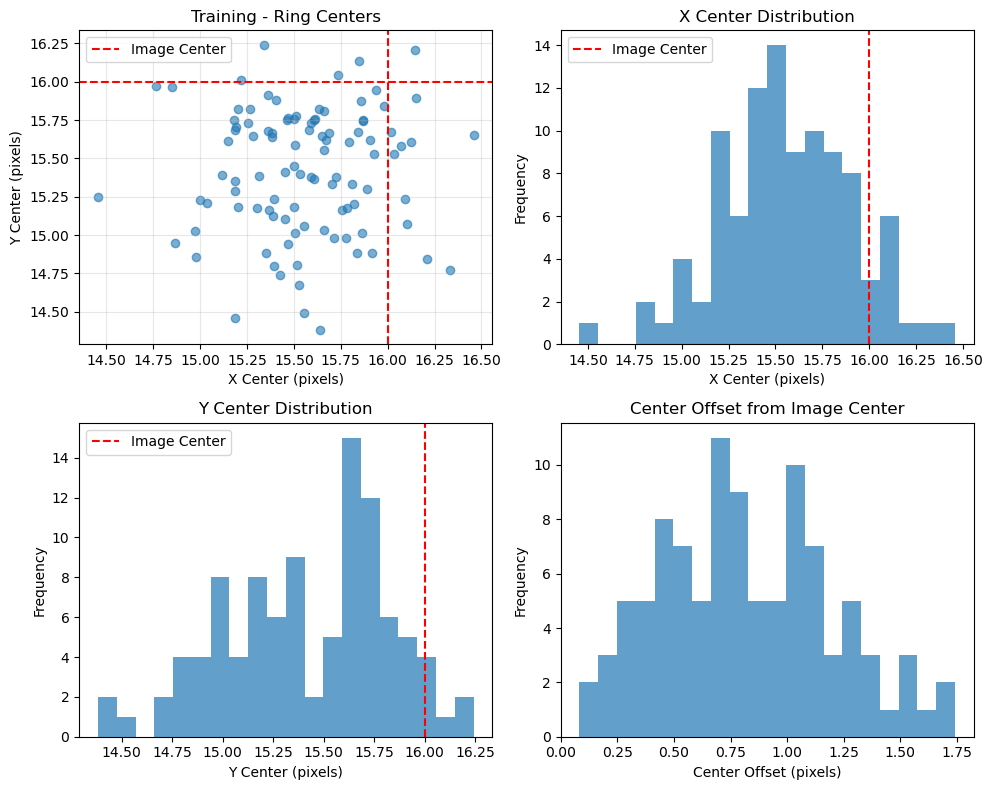

Mean center: (15.56, 15.42)
Std center: (0.36, 0.41)
Mean offset: 0.82 pixels
=== Testing Mass Reconstruction on Training Images ===
Training image 1:
  Ring radius: 0.0314 m
  Cherenkov angle: 1.800°
  Reconstructed mass: 0.3543 GeV/c²
  Expected mass: 0.13957 GeV/c²
  Ring quality: 0.934
  Center: (14.45, 15.25)
Training image 2: Unphysical mass result (theta_c: 1.839°)
Training image 3:
  Ring radius: 0.0316 m
  Cherenkov angle: 1.811°
  Reconstructed mass: 0.0667 GeV/c²
  Expected mass: 0.13957 GeV/c²
  Ring quality: 0.958
  Center: (15.40, 15.88)
Training image 4: Unphysical mass result (theta_c: 1.833°)
Training image 5: Unphysical mass result (theta_c: 1.822°)
Training image 6:
  Ring radius: 0.0309 m
  Cherenkov angle: 1.772°
  Reconstructed mass: 0.6569 GeV/c²
  Expected mass: 0.13957 GeV/c²
  Ring quality: 0.961
  Center: (15.84, 15.67)
Training image 7: Unphysical mass result (theta_c: 1.879°)
Training image 8: Unphysical mass result (theta_c: 1.827°)
Training image 9:
  Rin

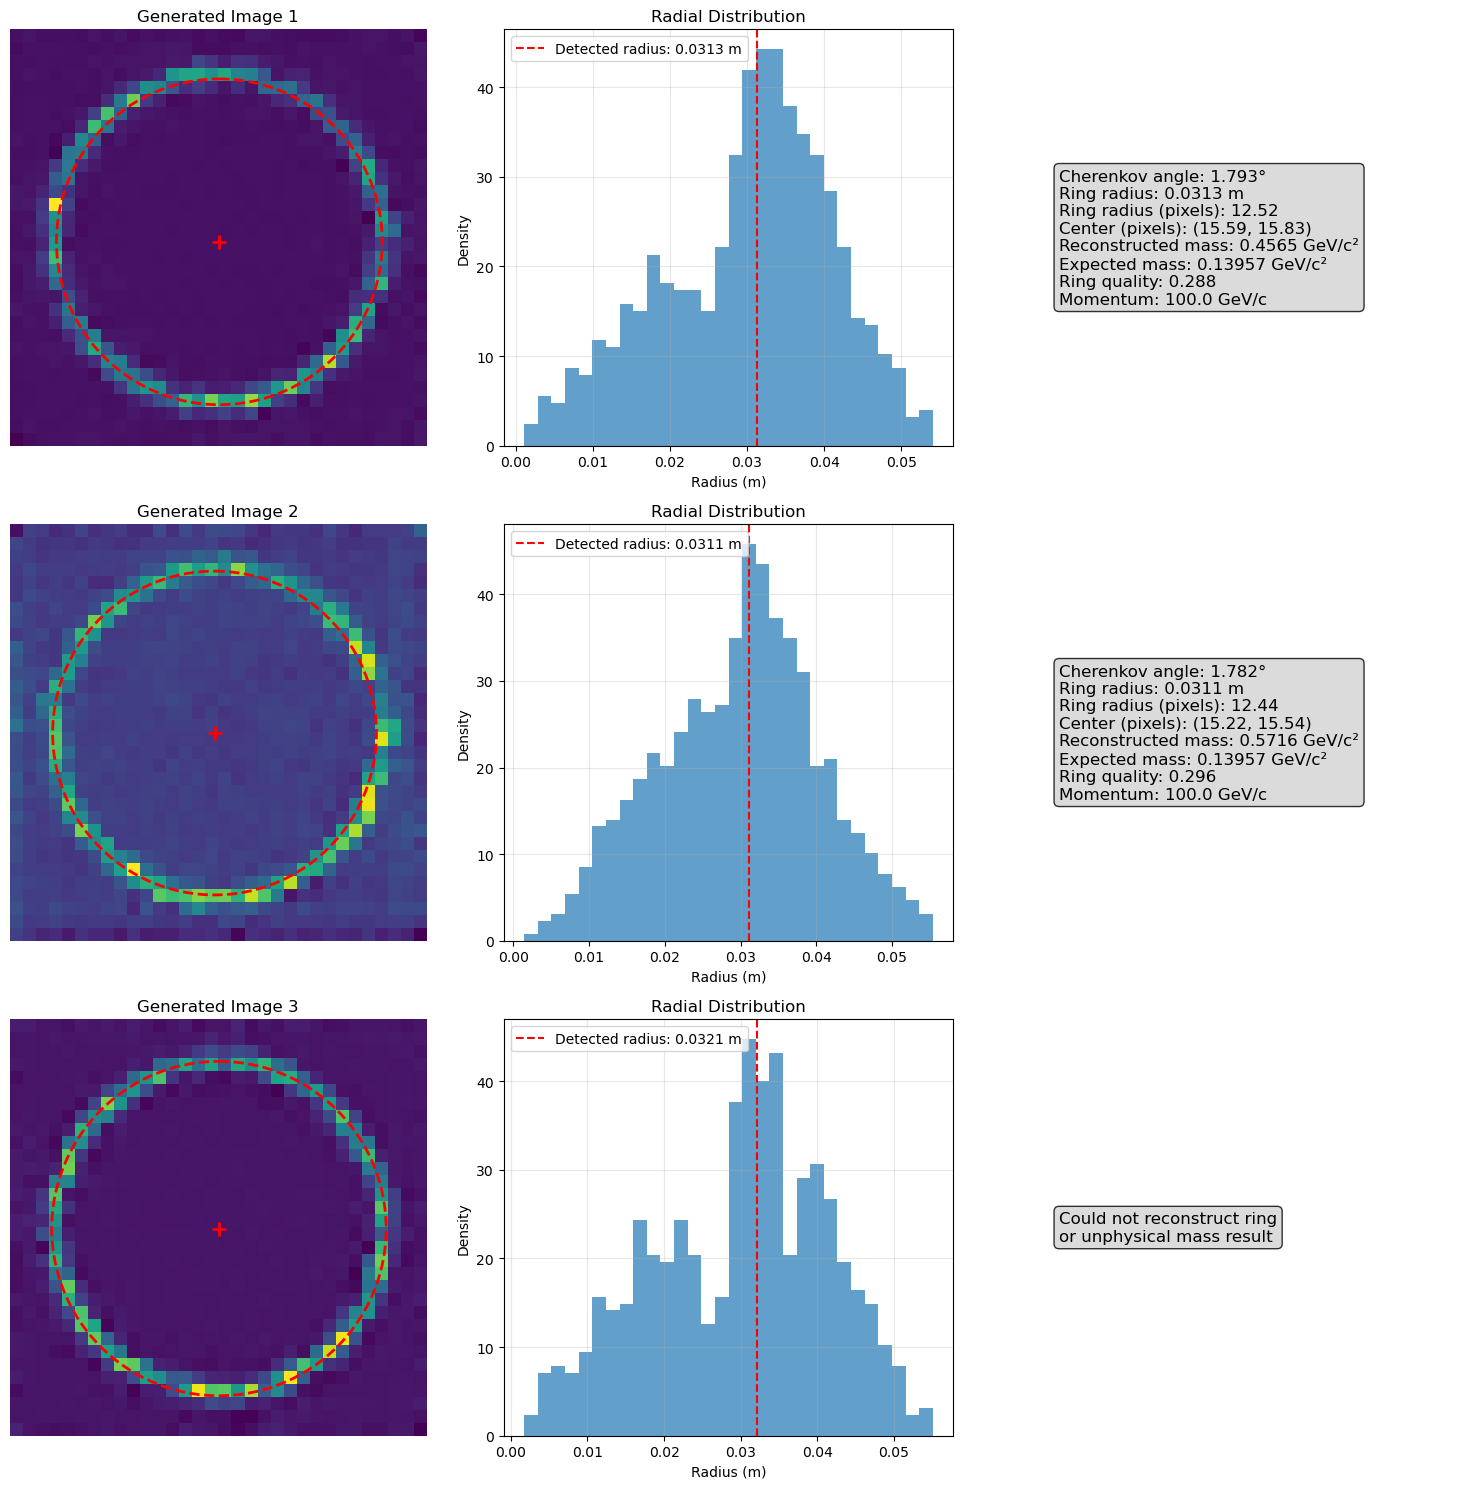


=== Side-by-Side Ring Comparison ===


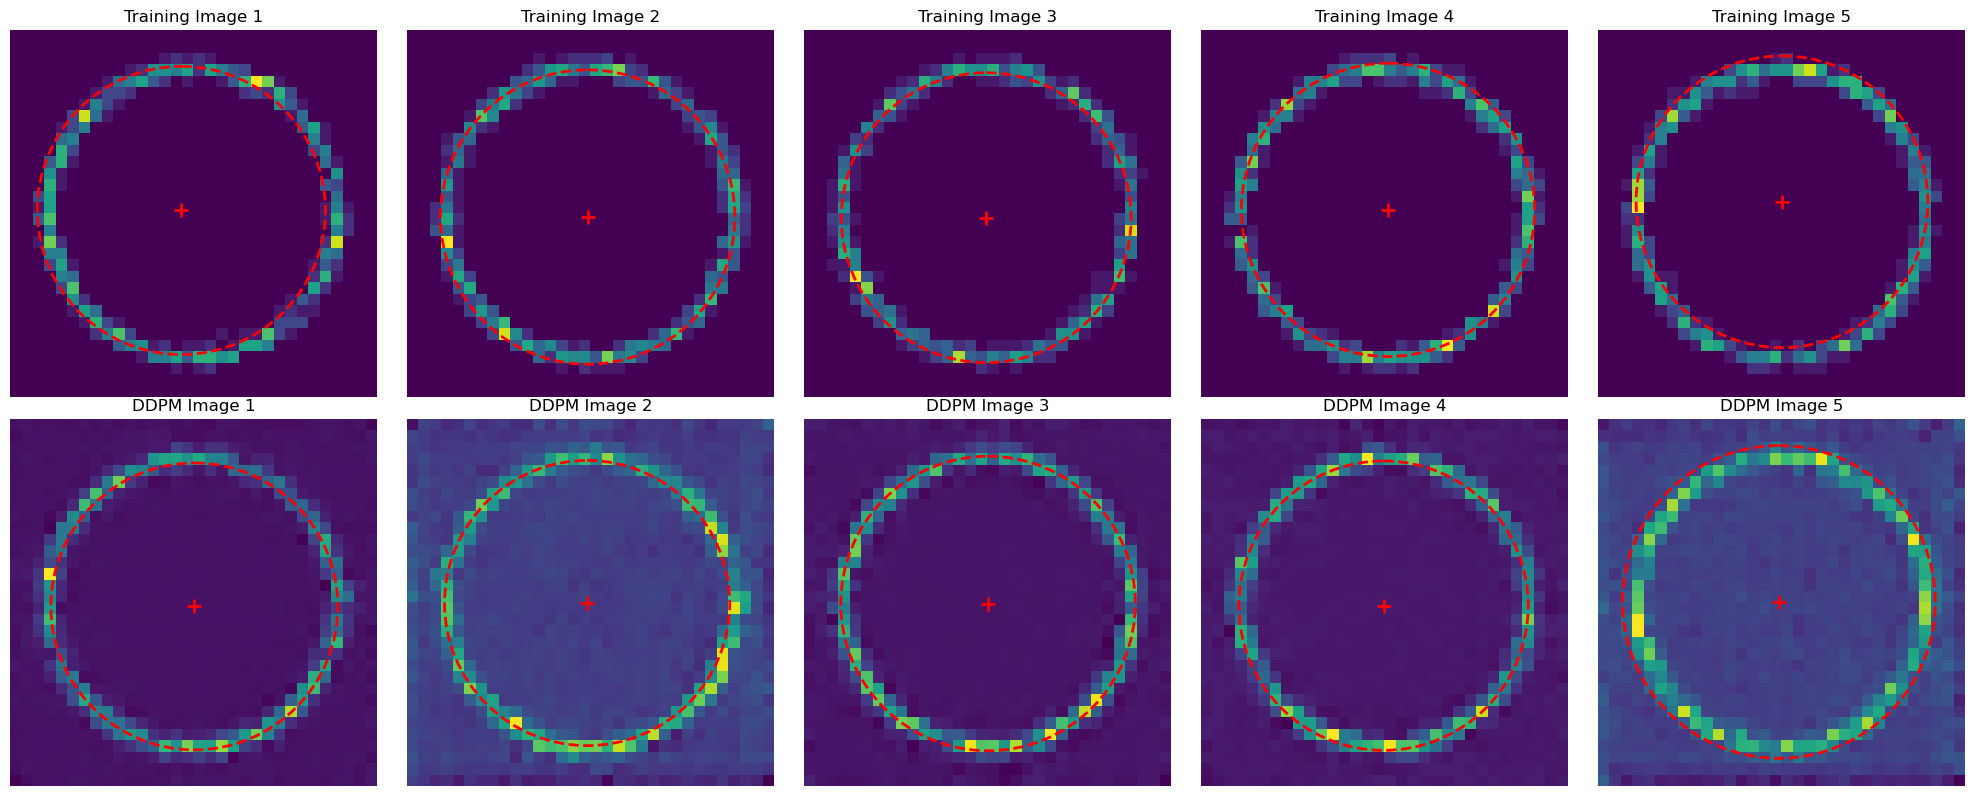

ValueError: too many values to unpack (expected 5)

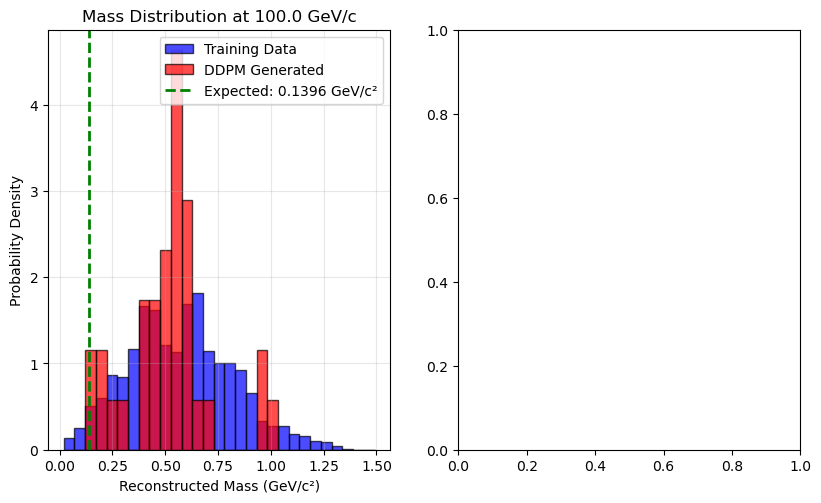

In [ ]:
# Load config and run analysis
with open('../config/default.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Use your actual training data
training_images_physical = ((normalised_images + 1) / 2.0) * max_value
training_images_physical = training_images_physical[..., 0]  # Remove channel dimension

print(f"Training images shape: {training_images_physical.shape}")
print(f"Training images range: [{training_images_physical.min():.3f}, {training_images_physical.max():.3f}]")

# Initialize analyzer and evaluator
analyzer = FixedMomentumRICHAnalyzer(config)
evaluator = FixedMomentumDDPMEvaluator(ddpm, unet, analyzer, config, fixed_momentum=10.0)
evaluator.set_training_data(training_images_physical)

# First, let's do detailed analysis of training images to understand the ring structure
print("=== Detailed Analysis of Training Images ===")
evaluator.plot_detailed_analysis(training_images_physical[:3], "Training")

# Plot radius distribution to see the spread of ring sizes
print("=== Radius Distribution Analysis ===")
evaluator.plot_radius_distribution(training_images_physical[:100], "Training")

# Test mass reconstruction on training images with proper error handling
print("=== Testing Mass Reconstruction on Training Images ===")
training_masses_sample = []
for i in range(10):
    theta_c, quality, radius, center = analyzer.reconstruct_cherenkov_angle(training_images_physical[i])
    if theta_c is not None and quality > 0.1:
        mass = analyzer.calculate_particle_mass(theta_c, 10.0)
        if mass is not None:
            ring_radius = np.tan(theta_c) * analyzer.detector_distance
            training_masses_sample.append(mass)
            print(f"Training image {i+1}:")
            print(f"  Ring radius: {radius:.4f} m")
            print(f"  Cherenkov angle: {np.degrees(theta_c):.3f}°")
            print(f"  Reconstructed mass: {mass:.4f} GeV/c²")
            print(f"  Expected mass: 0.13957 GeV/c²")
            print(f"  Ring quality: {quality:.3f}")
            print(f"  Center (fixed): ({center[0]:.1f}, {center[1]:.1f})")
        else:
            print(f"Training image {i+1}: Unphysical mass result (theta_c: {np.degrees(theta_c):.3f}°)")
    else:
        print(f"Training image {i+1}: Could not reconstruct ring or poor quality")

if training_masses_sample:
    print(f"\nSample training masses - Mean: {np.mean(training_masses_sample):.4f}, Std: {np.std(training_masses_sample):.4f}")
else:
    print("\nNo valid mass reconstructions in sample")

# Run the full evaluation
print("\n=== Running DDPM Evaluation ===")
results = evaluator.evaluate_mass_reconstruction(num_generated_images=100)

# Do detailed analysis of generated images
print("\n=== Detailed Analysis of Generated Images ===")
evaluator.plot_detailed_analysis(results['generated_images'][:3], "Generated")

# Create side-by-side comparison grid
print("\n=== Side-by-Side Ring Comparison ===")
evaluator.plot_ring_comparison_grid(training_images_physical[:5], results['generated_images'][:5])

# Create final comparison
metrics = evaluator.plot_mass_comparison(results)

print(f"\n=== Final Results ===")
print(f"KS test p-value: {metrics['ks_pvalue']:.4f}")
print(f"Mass bias: {metrics['bias_percent']:.2f}%")
print(f"Training mean mass: {metrics['training_mean']:.4f} ± {metrics['training_std']:.4f} GeV/c²")
print(f"DDPM mean mass: {metrics['ddpm_mean']:.4f} ± {metrics['ddpm_std']:.4f} GeV/c²")
print(f"Expected pion mass: {results['expected_mass']:.4f} GeV/c²")